In [4]:
pip install shutil

ERROR: Could not find a version that satisfies the requirement shutil
ERROR: No matching distribution found for shutil
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
import natsort
import shutil
from tqdm import tqdm
import cv2
from re import search

In [6]:
DIR='../input/plant-pathology-2020-fgvc7/images'
train=pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
test=pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')

In [7]:
train.head(5)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [8]:
test.head(5)

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


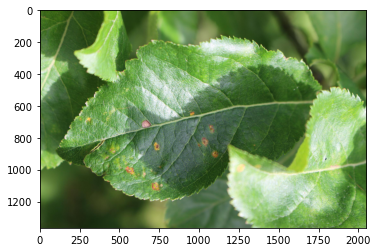

In [9]:
image_1=Image.open('../input/plant-pathology-2020-fgvc7/images/Test_1.jpg')
plt.imshow(image_1)
plt.show()

In [10]:
class_names=train.loc[:,'healthy':].columns
class_names

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')

In [11]:
num=0
train['label']=0
for i in class_names:
    train['label']=train['label']+train[i]*num
    num+=1

In [12]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [27]:
def get_label_image(img):
    if search('Train',img):
        img=img.split('.')[0]
        label=train.loc[train['image_id']==img]['label']
        return label
        

In [28]:
def creat_train_data():
    images=natsort.natsorted(os.listdir(DIR))
    for img in tqdm(images):
        label=get_label_image(img)
        path=os.path.join(DIR,img)
        
        if search('Train',img):
            if (img.split('_')[1].split('.')[0]) and label.item()==0:
                shutil.copy(path,'./train_images/healthy')
                
            elif (img.split('_')[1].split('.')[0]) and label.item()==1:
                shutil.copy(path,'./train_images/multiple_diseases')    
                
            elif (img.split('_')[1].split('.')[0]) and label.item()==2:
                shutil.copy(path,'./train_images/scab')
                
            elif (img.split('_')[1].split('.')[0]) and label.item()==3:
                shutil.copy(path,'./train_images/rust')    
                
        elif search('Test',img):
            shutil.copy(path,'./test_images/images')
            
            
    
    

In [ ]:
shutil.os.mkdir('./train_images')
shutil.os.mkdir('./test_images')
shutil.os.mkdir('./train_images/healthy')
shutil.os.mkdir('./train_images/multiple_diseases')
shutil.os.mkdir('./train_images/scab')
shutil.os.mkdir('./train_images/rust')

In [29]:
train_data=creat_train_data()

100%|██████████| 3642/3642 [00:22<00:00, 158.73it/s]


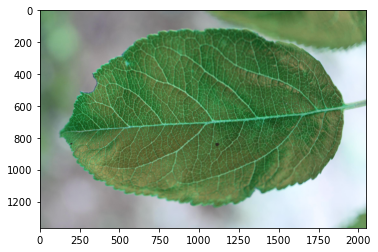

In [35]:
PATH='./train_images'
categories=['healthy','multiple_disease','rust','scab']

for cate in categories:
    path=os.path.join(PATH,cate)
    for img in os.listdir(path):
        image=cv2.imread(os.path.join(path,img))
        plt.imshow(image)
        plt.show()
        break
    break    

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D

In [40]:
datagen=ImageDataGenerator(rescale=1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           vertical_flip=True,
                          validation_split=0.25)

train_set=datagen.flow_from_directory('./train_images',
                                     target_size=(224,224),
                                     batch_size=16,
                                     class_mode='categorical',
                                     subset='training')

validation_set=datagen.flow_from_directory('./train_images',
                                     target_size=(224,224),
                                     batch_size=32,
                                     class_mode='categorical',
                                     subset='validation')

Found 1367 images belonging to 4 classes.
Found 454 images belonging to 4 classes.


In [51]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(224,224,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(32,activation='relu')),
model.add(Dense(4,activation='softmax'))

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 256)      

In [53]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [55]:
history=model.fit(train_set,validation_data=validation_set,epochs=20)

Epoch 1/20
43/43 [==============================] - 73s 2s/step - loss: 0.5849 - accuracy: 0.7762 - val_loss: 0.6369 - val_accuracy: 0.7577
Epoch 2/20
43/43 [==============================] - 73s 2s/step - loss: 0.5675 - accuracy: 0.7769 - val_loss: 0.5286 - val_accuracy: 0.7665
Epoch 3/20
43/43 [==============================] - 72s 2s/step - loss: 0.5540 - accuracy: 0.7930 - val_loss: 0.4752 - val_accuracy: 0.7996
Epoch 4/20
43/43 [==============================] - 71s 2s/step - loss: 0.5221 - accuracy: 0.7981 - val_loss: 0.5517 - val_accuracy: 0.7797
Epoch 5/20
43/43 [==============================] - 71s 2s/step - loss: 0.4633 - accuracy: 0.8237 - val_loss: 0.4684 - val_accuracy: 0.8194
Epoch 6/20
43/43 [==============================] - 72s 2s/step - loss: 0.4264 - accuracy: 0.8325 - val_loss: 0.3798 - val_accuracy: 0.8744
Epoch 7/20
43/43 [==============================] - 71s 2s/step - loss: 0.3879 - accuracy: 0.8552 - val_loss: 0.3644 - val_accuracy: 0.8722
Epoch 8/20
43/43 [==

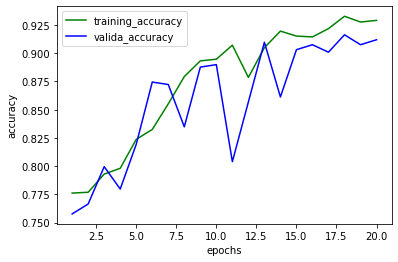

In [57]:
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1,21)
plt.plot(epochs,train_acc,'g',label='training_accuracy')
plt.plot(epochs,val_acc,'b',label='valida_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

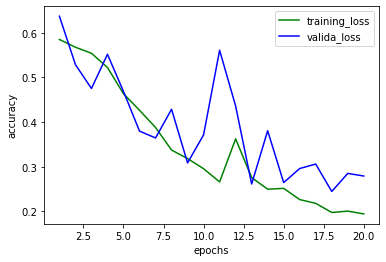

In [62]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,21)
plt.plot(epochs,train_loss,'g',label='training_loss')
plt.plot(epochs,val_loss,'b',label='valida_loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [82]:
def prediction(test_image):
    image_result=Image.open(test_image)

    from tensorflow.keras.preprocessing import image
    test_image=image.load_img(test_image,target_size=(224,224))
    test_image=image.img_to_array(test_image)
    test_image=test_image/255
    test_image=np.expand_dims(test_image,axis=0)
    result=model.predict(test_image)
    print(np.argmax(result))
    Categories=['healthy','multiple_disease','rust','scab']
    image_result=plt.imshow(image_result)
    plt.title(Categories[np.argmax(result)])
    plt.show()

2


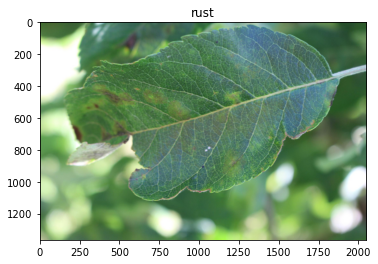

In [83]:
prediction('../input/plant-pathology-2020-fgvc7/images/Test_1003.jpg')

0


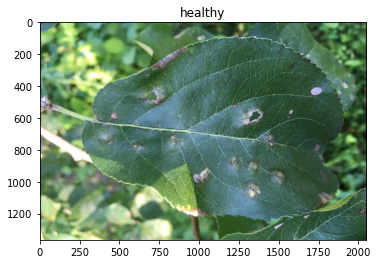

In [85]:
prediction('../input/plant-pathology-2020-fgvc7/images/Test_103.jpg')

3


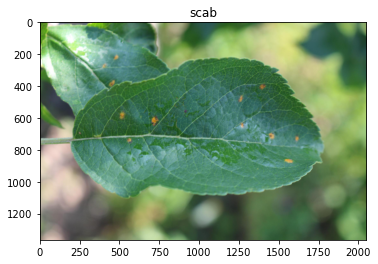

In [86]:
prediction('../input/plant-pathology-2020-fgvc7/images/Test_193.jpg')

In [ ]:
model.save('foliar.h5')